# Model Compression Experiment (example on: Transformer)

This notebook implements various model compression techniques for the Transformer model (*) used in solar radiation forecasting:
1. **Quantization**: Reducing model precision to decrease size and improve inference speed
2. **Structured Pruning**: Removing less important components to reduce parameters
3. **Knowledge Distillation**: Training a smaller model to mimic the larger model's behavior

(*) This notebook is tested on Transformer model, but you can choose other model (e.g. Informer, iTransformer, etc.) checkpoint as well.
Just note to update the student model arguments in Technique 3 if you choose other model.

## Debug Mode

**IMPORTANT**: Set to True for code debugging mode and False for actual training.
In debug mode, the code will only run 10 batches/epoch for 10 epochs.

In [1]:
# Debug mode to test code. Set to False for actual training
DEBUG_MODE = False


## 0. Setup and Load Trained Model

In [2]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 2
%autoreload 2

from datetime import datetime
import json
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import copy
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
import wandb

# Import project utilities
from utils.model_utils import load_model, save_model, print_model_info
from utils.data_persistence import load_scalers
from utils.plot_utils import plot_predictions_over_time
from utils.timeseriesdataset import TimeSeriesDataset
from utils.training_utils import evaluate_model, evaluate_inference_time
from utils.wandb_utils import track_experiment, is_wandb_enabled

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Choose the model checkpoint from the previous experiment
PRETRAINED_MODEL_PATH = "checkpoints/Transformer_best_20250507_184033.pt"

# Data settings
TRAIN_PREPROCESSED_DATA_PATH = "data/processed/train_normalized_20250430_145157.h5"
VAL_PREPROCESSED_DATA_PATH = "data/processed/val_normalized_20250430_145205.h5"
TEST_PREPROCESSED_DATA_PATH = "data/processed/test_normalized_20250430_145205.h5"
SCALER_PATH = "data/processed/scalers_20250430_145206.pkl"

# Dataset settings
LOOKBACK = 24
TARGET_VARIABLE = "ghi"
SELECTED_FEATURES = [
    'air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type',
    'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water',
    'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'
]
STATIC_FEATURES = ['latitude', 'longitude', 'elevation']
TIME_FEATURES = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
if DEBUG_MODE:
    BATCH_SIZE = 2**10
    NUM_WORKERS = 4
else:
    BATCH_SIZE = 2**13
    NUM_WORKERS = 16


Using device: cuda


## Helper Functions for Evaluation

In [3]:
def get_model_size(model):
    """Get model size in MB."""
    torch_model_size = 0
    for param in model.parameters():
        torch_model_size += param.nelement() * param.element_size()
    torch_model_size_mb = torch_model_size / (1024 * 1024)
    return torch_model_size_mb

def print_model_report(model_name, model, test_loader, scalers, device=device):
    """Print a comprehensive report about the model."""
    model_size = get_model_size(model)

    # Use the project's evaluate_model function instead of custom evaluation logic
    eval_metrics = evaluate_model(
        model=model,
        data_loader=test_loader,
        target_scaler=scalers.get('ghi_scaler', None),
        model_name=model_name,
        log_to_wandb=False,
        device=device,
        debug_mode=DEBUG_MODE
    )
    # Evaluate inference time
    timing_metrics = evaluate_inference_time(model,
                                             test_loader,
                                             model_name=f"{model_name} - Test",
                                             log_to_wandb=False,
                                             timing_iterations=3,
                                             device=device,
                                             debug_mode=DEBUG_MODE)
    eval_metrics.update(timing_metrics)
    # Get inference time from the evaluation metrics
    inference_time = eval_metrics['total_inference_time']

    # Extract test loss (MSE) from the evaluation metrics
    test_loss = eval_metrics['mse']

    print(f"=== {model_name} ===")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Inference Time: {inference_time*1000:.2f} ms")
    print(f"Test Loss: {test_loss:.4f}")
    if 'mae' in eval_metrics:
        print(f"Test MAE: {eval_metrics['mae']:.4f}")
    if 'r2' in eval_metrics:
        print(f"Test R²: {eval_metrics['r2']:.4f}")
    print()

    return {
        'name': model_name,
        'size': model_size,
        'inference_time': inference_time,
        'test_loss': test_loss,
        'metrics': eval_metrics
    }


## Load and Prepare Data

In [4]:
# Load scalers
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(TRAIN_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                 selected_features=SELECTED_FEATURES, include_target_history=False,
                                 static_features=STATIC_FEATURES)
val_dataset = TimeSeriesDataset(VAL_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                               selected_features=SELECTED_FEATURES, include_target_history=False,
                               static_features=STATIC_FEATURES)
test_dataset = TimeSeriesDataset(TEST_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                selected_features=SELECTED_FEATURES, include_target_history=False,
                                static_features=STATIC_FEATURES)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

scalers = load_scalers(SCALER_PATH)

# Get sample input for inference time measurement
sample_batch = next(iter(test_loader))
sample_temporal = sample_batch['temporal_features'][0:1].to(device)
sample_static = sample_batch['static_features'][0:1].to(device)
sample_input = (sample_temporal, sample_static)

print("Data loading successful.")


Using time feature keys: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Using static features: ['latitude', 'longitude', 'elevation']
Not using target field history for autoregression
Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded normalized data file (1/1): data/processed/train_normalized_20250430_145157.h5
Loaded data with 27 features
Using 11 selected features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Temporal features: ['day_cos', 'day_sin', 'dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']
Static features: ['latitude', 'longitude', 'elevation']
Time series features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total

## Load Original Model

In [5]:

print(f"Loading model from {PRETRAINED_MODEL_PATH}")
original_model, metadata = load_model(PRETRAINED_MODEL_PATH, device=device)
base_checkpoint_name = os.path.splitext(os.path.basename(PRETRAINED_MODEL_PATH))[0]
model_name = metadata['model_name']
# Print model information
print_model_info(original_model,
                temporal_shape=sample_input[0].shape,
                static_shape=sample_input[1].shape)

# Warm up the model to avoid first batch overhead
print("Warming up model...")
n_warmup_batches = 10
original_model.eval()
with torch.no_grad():
    for i in range(n_warmup_batches):
        batch = next(iter(test_loader))
        temporal_features = batch['temporal_features'].to(device)
        static_features = batch['static_features'].to(device)
        original_model(temporal_features, static_features)
print("Model warmed up.")

# Evaluate original model
original_metrics = print_model_report(model_name, original_model, test_loader, scalers, device=device)


Loading model from checkpoints/Transformer_best_20250507_184033.pt
Dynamically imported model class: TransformerModel from models.transformer
Model TransformerModel requires parameters: ['input_dim', 'static_dim']
Model TransformerModel optional parameters: ['d_model', 'n_heads', 'e_layers', 'd_ff', 'dropout', 'activation']
Filtering out unexpected parameter: call_super_init
Filtering out unexpected parameter: dump_patches
Filtering out unexpected parameter: training
Creating model with parameters: {'activation': 'gelu', 'd_ff': 256, 'd_model': 128, 'dropout': 0.1, 'e_layers': 2, 'input_dim': 19, 'n_heads': 4, 'static_dim': 3}
Loaded TransformerModel model from checkpoints/Transformer_best_20250507_184033.pt
  Saved date: 2025-05-07 18:40:33
  PyTorch version used for saving: 2.6.0+cu124
  Temporal features: hour_sin, hour_cos, day_sin, day_cos, month_sin, month_cos, dow_sin, dow_cos, air_temperature, wind_speed, relative_humidity, cloud_type, solar_zenith_angle, clearsky_ghi, total_pr


Transformer Evaluation Metrics:
  Overall:  MSE: 2816.77, RMSE: 53.07, MAE: 24.26, R²: 0.9696, MASE: 0.48
  Daytime:  MSE: 5653.55, RMSE: 75.19, MAE: 47.85, R²: 0.9313, MASE: 0.47
  Nighttime: MSE: 0.93, RMSE: 0.96, MAE: 0.84, R²: 0.6449, MASE: 8.24



Transformer - Test Timing Metrics:
  Inference Speed: 242555.16 samples/sec, 4.1228 μs/sample
  Total time: 3.7921 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0098s, max=0.0340s, std=0.0023s
=== Transformer ===
Model Size: 1.07 MB
Inference Time: 3792.13 ms
Test Loss: 2816.7666
Test MAE: 24.2582
Test R²: 0.9696



### Visualize Model Predictions Over Time
Check if the model is loaded correctly

Generating predictions visualization...
Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


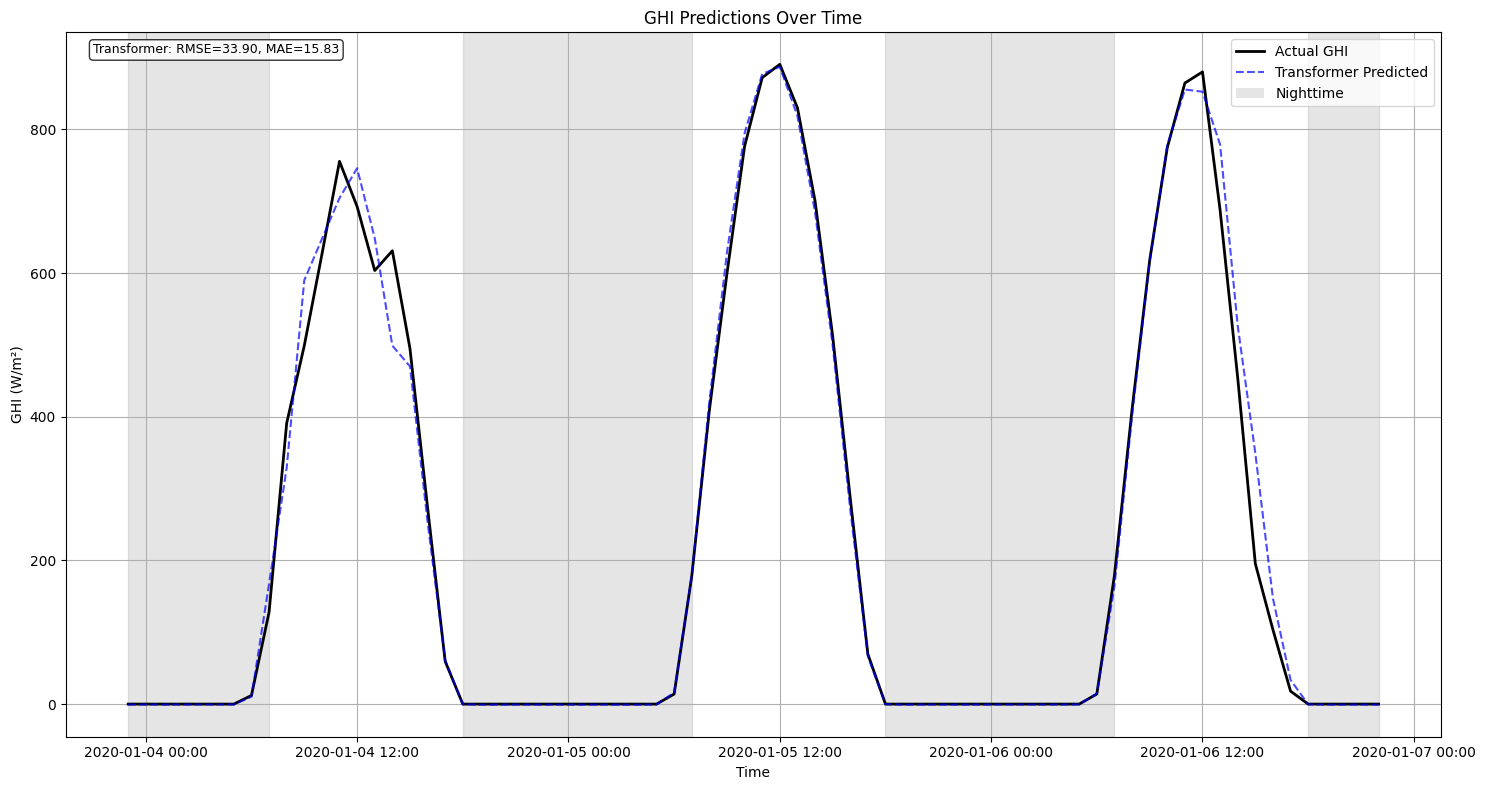

In [6]:
# Define target scaler from the data_metadata
target_scaler = scalers.get(f'{TARGET_VARIABLE}_scaler')
if target_scaler is None:
    print(f"Warning: No scaler found for target field '{TARGET_VARIABLE}'. Visualization may show scaled values.")

# Visualize the loaded model's predictions
print("Generating predictions visualization...")
original_model.eval()  # Set model to evaluation mode

# Create the visualization using the imported function
viz_fig = plot_predictions_over_time(
    models=[original_model],
    model_names=[model_name],
    data_loader=test_loader,
    target_scaler=target_scaler,
    num_samples=72,  # Adjust as needed
    start_idx=40,
    device=device       # Adjust as needed
)
plt.show()


## Technique 1: Quantization

Quantization reduces model precision from float32 to int8 to decrease model size and improve inference speed.

The quantization in this section is done with ONNX Runtime on CPU (section 1a and 1b) and GPU (section 1c).

Require libraries:
- onnx
- onnxruntime

## Technique 1a: Int8 Quantization with ONNX (CPU)

This section demonstrates exporting the PyTorch model to ONNX format and applying ONNX dynamic quantization for model efficiency.

Steps:
1. Export the original PyTorch model to ONNX
2. Quantize the ONNX model with ONNX Runtime
3. Evaluate the quantized model

In [7]:
# Define an ONNX wrapper to preserve batch dimension in the output
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
import onnxruntime as ort

class OnnxModelWrapper(nn.Module):
    def __init__(self, model):
        super(OnnxModelWrapper, self).__init__()
        self.model = model

    def forward(self, temporal_features, static_features):
        outputs = self.model(temporal_features, static_features)
        return outputs

# Define device (use CPU for 'fbgemm')
cpu_device = torch.device('cpu')

# Prepare wrapper and CPU sample input
wrapper = OnnxModelWrapper(original_model).eval().to(cpu_device)
sample_input_cpu = (sample_input[0].cpu(), sample_input[1].cpu())

# Export the original model to ONNX
onnx_model_path = f"checkpoints/{base_checkpoint_name}_original.onnx"
print(f"Exporting original model to ONNX at {onnx_model_path}")
torch.onnx.export(
    wrapper,
    sample_input_cpu,
    onnx_model_path,
    input_names=["temporal_features", "static_features"],
    output_names=["output"],
    opset_version=20,
    dynamic_axes={
        "temporal_features": {0: "batch"},
        "static_features": {0: "batch"},
        "output": {0: "batch"},
    },
)
# File size before quantization
orig_onnx_size = os.path.getsize(onnx_model_path) / (1024 * 1024)
print(f"Original ONNX model size: {orig_onnx_size:.2f} MB")

# Apply dynamic quantization with ONNX Runtime
quantized_onnx_model_path = f"checkpoints/{base_checkpoint_name}_quantized_int8.onnx"
print(f"Quantizing ONNX model to {quantized_onnx_model_path}")
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=quantized_onnx_model_path,
    weight_type=QuantType.QUInt8
)

# Run ONNX shape inference to populate output shape info and avoid mismatches
print("Running ONNX shape inference for original and quantized models...")
# Original ONNX model shape inference
model_proto = onnx.load(onnx_model_path)
inferred_model = onnx.shape_inference.infer_shapes(model_proto)
onnx.save(inferred_model, onnx_model_path)
# Quantized ONNX model shape inference
model_q_proto = onnx.load(quantized_onnx_model_path)
inferred_q_model = onnx.shape_inference.infer_shapes(model_q_proto)
onnx.save(inferred_q_model, quantized_onnx_model_path)

# Only annotate batch dimension if missing
for model_path in [onnx_model_path, quantized_onnx_model_path]:
    m = onnx.load(model_path)
    for output in m.graph.output:
        shape = output.type.tensor_type.shape
        # Ensure dynamic batch dimension exists
        if len(shape.dim) == 0:
            dim0 = shape.dim.add()
            dim0.dim_param = "batch"
    onnx.save(m, model_path)

quant_onnx_size = os.path.getsize(quantized_onnx_model_path) / (1024 * 1024)
print(f"Quantized ONNX model size: {quant_onnx_size:.2f} MB")
print()

# Helper function to evaluate ONNX models over the full test set
def evaluate_onnx_model(model_path, debug_mode=False):
    sess = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])
    input_name1 = sess.get_inputs()[0].name
    input_name2 = sess.get_inputs()[1].name
    # Warm-up on the first batch to initialize optimizations
    first_batch = next(iter(test_loader))
    warm_inp1 = first_batch['temporal_features'].numpy()
    warm_inp2 = first_batch['static_features'].numpy()
    for _ in range(5):
        sess.run(None, {input_name1: warm_inp1, input_name2: warm_inp2})
    # Measure inference time over all batches and collect outputs for MAE
    total_time = 0.0
    num_batches = 0
    all_preds = []
    all_targets = []
    debug_counter = 0
    for batch in tqdm(test_loader, desc=f"ONNX inference ({os.path.basename(model_path)})"):
        inp1 = batch['temporal_features'].numpy()
        inp2 = batch['static_features'].numpy()
        targets = batch['target'].numpy()
        start = time.time()
        outputs = sess.run(None, {input_name1: inp1, input_name2: inp2})[0]
        elapsed = time.time() - start
        total_time += elapsed
        num_batches += 1
        all_preds.append(outputs)
        all_targets.append(targets)

        debug_counter += 1
        if debug_mode and debug_counter > 10:
            break
    avg_time = total_time / num_batches if num_batches > 0 else 0.0
    # Concatenate and inverse-transform
    preds = np.concatenate(all_preds, axis=0)
    targets_arr = np.concatenate(all_targets, axis=0)
    # Inverse scale if available
    scaler = scalers.get(f"{TARGET_VARIABLE}_scaler", None)
    if scaler is not None:
        preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        targets_arr = scaler.inverse_transform(targets_arr.reshape(-1, 1)).flatten()
    # Compute MAE via sklearn
    mae_value = mean_absolute_error(targets_arr, preds)
    print(f"Inference time for {os.path.basename(model_path)}: {avg_time*1000:.2f} ms per batch over {num_batches} batches")
    print(f"MAE for {os.path.basename(model_path)}: {mae_value:.4f}")
    return {'size': os.path.getsize(model_path)/(1024*1024), 'inference_time': avg_time, 'mae': mae_value}

# Technique 1a: ONNX CPU Quantization Results
print("\n===== Technique 1a: ONNX CPU Quantization Results =====")
onnx_orig_metrics = evaluate_onnx_model(onnx_model_path, debug_mode=DEBUG_MODE)
onnx_int8_metrics = evaluate_onnx_model(quantized_onnx_model_path, debug_mode=DEBUG_MODE)
print(f"{'Model':<30}{'Size (MB)':<12}{'Latency(ms)':<15}{'MAE':<10}")
print('-'*67)
print(f"{'Original ONNX CPU':<30}{onnx_orig_metrics['size']:<12.2f}{onnx_orig_metrics['inference_time']*1000:<15.2f}{onnx_orig_metrics['mae']:<10.4f}")
print(f"{'Int8 ONNX CPU':<30}{onnx_int8_metrics['size']:<12.2f}{onnx_int8_metrics['inference_time']*1000:<15.2f}{onnx_int8_metrics['mae']:<10.4f}")
print()


Exporting original model to ONNX at checkpoints/Transformer_best_20250507_184033_original.onnx


Original ONNX model size: 1.19 MB
Quantizing ONNX model to checkpoints/Transformer_best_20250507_184033_quantized_int8.onnx
Running ONNX shape inference for original and quantized models...
Quantized ONNX model size: 0.44 MB


===== Technique 1a: ONNX CPU Quantization Results =====


ONNX inference (Transformer_best_20250507_184033_original.onnx): 100%|██████████| 113/113 [01:08<00:00,  1.65it/s]


Inference time for Transformer_best_20250507_184033_original.onnx: 547.61 ms per batch over 113 batches
MAE for Transformer_best_20250507_184033_original.onnx: 24.2574


ONNX inference (Transformer_best_20250507_184033_quantized_int8.onnx): 100%|██████████| 113/113 [01:04<00:00,  1.74it/s]


Inference time for Transformer_best_20250507_184033_quantized_int8.onnx: 519.88 ms per batch over 113 batches
MAE for Transformer_best_20250507_184033_quantized_int8.onnx: 25.2368
Model                         Size (MB)   Latency(ms)    MAE       
-------------------------------------------------------------------
Original ONNX CPU             1.21        547.61         24.2574   
Int8 ONNX CPU                 0.44        519.88         25.2368   



## Technique 1b: Int4 Quantization with ONNX (CPU)

Int4 quantization is an extreme form of quantization that reduces model weights to 4-bit integers.
This technique significantly reduces model size with some potential impact on accuracy.
It's especially effective for large transformer models.

In [8]:
print("\n===== Technique 1b: ONNX Int4 Quantization =====")

from onnxruntime.quantization import (
    matmul_4bits_quantizer,
    quant_utils,
)
from pathlib import Path

# Define input/output paths
model_fp32_path = onnx_model_path  # Re-use the original FP32 ONNX model
model_int4_path = f"checkpoints/{base_checkpoint_name}_quantized_int4.onnx"

print(f"Creating Int4 quantized model at {model_int4_path}")

# Configure Int4 quantization settings
quant_config = matmul_4bits_quantizer.DefaultWeightOnlyQuantConfig(
    block_size=128,  # 2's exponential and >= 16
    is_symmetric=True,  # if true, quantize to Int4, otherwise, quantize to uint4
    accuracy_level=4,  # used by MatMulNbits
    quant_format=quant_utils.QuantFormat.QOperator,
    op_types_to_quantize=("MatMul", "Gather"),  # specify which op types to quantize
    quant_axes=(("MatMul", 0), ("Gather", 1),)  # specify which axis to quantize for an op type
)

# Load the model with shape inference
model = quant_utils.load_model_with_shape_infer(Path(model_fp32_path))

# Create the quantizer
quant = matmul_4bits_quantizer.MatMul4BitsQuantizer(
    model,
    nodes_to_exclude=None,  # specify a list of nodes to exclude from quantization
    nodes_to_include=None,  # specify a list of nodes to force include from quantization
    algo_config=quant_config,
)

# Apply quantization
quant.process()

# Save the quantized model
quant.model.save_model_to_file(
    model_int4_path,
    True  # save data to external file
)

quant_int4_size = os.path.getsize(model_int4_path) / (1024 * 1024)
print(f"Int4 Quantized ONNX model size: {quant_int4_size:.2f} MB")
print(f"Size reduction: {(orig_onnx_size - quant_int4_size) / orig_onnx_size * 100:.2f}%")

# Evaluate Int4 model
print("\nEvaluating Int4 quantized model on CPU...")
onnx_int4_metrics = evaluate_onnx_model(model_int4_path, debug_mode=DEBUG_MODE)

# Add to our comparison table
print("\n===== Int4 Quantization Results =====")
print(f"{'Model':<30}{'Size (MB)':<12}{'Latency(ms)':<15}{'MAE':<10}")
print('-'*67)
print(f"{'Original ONNX CPU':<30}{onnx_orig_metrics['size']:<12.2f}{onnx_orig_metrics['inference_time']*1000:<15.2f}{onnx_orig_metrics['mae']:<10.4f}")
print(f"{'Int8 ONNX CPU':<30}{onnx_int8_metrics['size']:<12.2f}{onnx_int8_metrics['inference_time']*1000:<15.2f}{onnx_int8_metrics['mae']:<10.4f}")
print(f"{'Int4 ONNX CPU':<30}{onnx_int4_metrics['size']:<12.2f}{onnx_int4_metrics['inference_time']*1000:<15.2f}{onnx_int4_metrics['mae']:<10.4f}")
print()



===== Technique 1b: ONNX Int4 Quantization =====
Creating Int4 quantized model at checkpoints/Transformer_best_20250507_184033_quantized_int4.onnx
Int4 Quantized ONNX model size: 0.11 MB
Size reduction: 91.12%

Evaluating Int4 quantized model on CPU...


ONNX inference (Transformer_best_20250507_184033_quantized_int4.onnx): 100%|██████████| 113/113 [01:13<00:00,  1.55it/s]

Inference time for Transformer_best_20250507_184033_quantized_int4.onnx: 589.69 ms per batch over 113 batches
MAE for Transformer_best_20250507_184033_quantized_int4.onnx: 25.6036

===== Int4 Quantization Results =====
Model                         Size (MB)   Latency(ms)    MAE       
-------------------------------------------------------------------
Original ONNX CPU             1.21        547.61         24.2574   
Int8 ONNX CPU                 0.44        519.88         25.2368   
Int4 ONNX CPU                 0.11        589.69         25.6036   



## Technique 1c: FP16 Quantization (Requires CUDA GPU)

FP16 quantization is a technique that converts the model to FP16 precision to reduce memory usage and improve inference speed.

Require libraries:
- onnxconverter-common
- onnxruntime-gpu

In [9]:
# Helper function to evaluate ONNX models on GPU
def evaluate_onnx_model_gpu(model_path, provider='CUDAExecutionProvider', fp16_mode=False, debug_mode=False):
    # Configure session options to optimize for GPU
    sess_options = ort.SessionOptions()
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    # Silence provider assignment warnings - these are expected and normal
    sess_options.add_session_config_entry("session.log.severity", "2")  # Set log level to WARNING (2) or ERROR (3)
    sess_options.log_severity_level = 2

    # Create inference session with CUDA provider
    # Add CPU provider as a fallback because not all operations are supported on GPU
    providers = [provider, 'CPUExecutionProvider']
    session = ort.InferenceSession(
        model_path,
        providers=providers,
        sess_options=sess_options
    )

    input_name1 = session.get_inputs()[0].name
    input_name2 = session.get_inputs()[1].name

    # Get a small batch for warm-up
    first_batch = next(iter(test_loader))
    warm_inp1 = first_batch['temporal_features'].numpy()
    warm_inp2 = first_batch['static_features'].numpy()

    # Convert inputs to FP16 if running in FP16 mode
    if fp16_mode:
        warm_inp1 = warm_inp1.astype(np.float16)
        warm_inp2 = warm_inp2.astype(np.float16)

    # Warm up with a few iterations
    print(f"Warming up GPU ONNX model with provider: {provider}...")
    for _ in range(10):  # More warm-up iterations for GPU
        session.run(None, {input_name1: warm_inp1, input_name2: warm_inp2})

    # Measure inference time and MAE
    total_time = 0.0
    num_batches = 0
    all_preds = []
    all_targets = []
    debug_counter = 0
    for batch in tqdm(test_loader, desc=f"GPU ONNX inference ({os.path.basename(model_path)})"):
        inp1 = batch['temporal_features'].numpy()
        inp2 = batch['static_features'].numpy()
        targets = batch['target'].numpy()

        # Convert inputs to FP16 if running in FP16 mode
        if fp16_mode:
            inp1 = inp1.astype(np.float16)
            inp2 = inp2.astype(np.float16)

        # Sync CUDA before timing
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        start = time.time()
        outputs = session.run(None, {input_name1: inp1, input_name2: inp2})[0]

        # Sync CUDA after inference for accurate timing
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        elapsed = time.time() - start
        total_time += elapsed
        num_batches += 1

        all_preds.append(outputs)
        all_targets.append(targets)

        debug_counter += 1
        if debug_mode and debug_counter > 10:
            break

    avg_time = total_time / num_batches if num_batches > 0 else 0.0

    # Calculate MAE (same as before)
    preds = np.concatenate(all_preds, axis=0)
    targets_arr = np.concatenate(all_targets, axis=0)

    scaler = scalers.get(f"{TARGET_VARIABLE}_scaler", None)
    if scaler is not None:
        preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        targets_arr = scaler.inverse_transform(targets_arr.reshape(-1, 1)).flatten()

    mae_value = mean_absolute_error(targets_arr, preds)

    print(f"GPU Inference time for {os.path.basename(model_path)}: {avg_time*1000:.2f} ms per batch over {num_batches} batches")
    print(f"MAE for {os.path.basename(model_path)}: {mae_value:.4f}")

    return {
        'size': os.path.getsize(model_path)/(1024*1024),
        'inference_time': avg_time,
        'mae': mae_value,
        'provider': provider
    }

# Create an FP16 quantized model specifically for GPU
quantized_fp16_path = f"checkpoints/{base_checkpoint_name}_quantized_fp16.onnx"
print(f"Creating FP16 quantized model for GPU at {quantized_fp16_path}")

# Use the convert_float_to_float16 utility from ONNX
from onnxconverter_common import float16
model_fp16 = float16.convert_float_to_float16(
    model=model_proto,
    min_positive_val=1e-7,
    max_finite_val=1e4,
)
for output in model_fp16.graph.output:
    shape = output.type.tensor_type.shape
    # Ensure dynamic batch dimension exists
    if len(shape.dim) == 0:
        dim0 = shape.dim.add()
        dim0.dim_param = "batch"
onnx.save(model_fp16, quantized_fp16_path)

# First evaluate the original model on GPU for baseline comparison
print("\nEvaluating original (FP32) ONNX model on GPU...")
onnx_gpu_metrics = evaluate_onnx_model_gpu(onnx_model_path, fp16_mode=False, debug_mode=DEBUG_MODE)

# Evaluate the FP16 model on GPU
print("\nEvaluating FP16 quantized model on GPU...")
onnx_fp16_metrics = evaluate_onnx_model_gpu(quantized_fp16_path, fp16_mode=True, debug_mode=DEBUG_MODE)

# Technique 1b: ONNX GPU Quantization Results (FP32 vs FP16 vs INT8)
print("\n===== Technique 1b: ONNX GPU Quantization Results =====")
print(f"{'Model':<30}{'Size (MB)':<12}{'Latency(ms)':<15}{'MAE':<10}")
print('-'*67)
print(f"{'Original ONNX GPU (FP32)':<30}{onnx_gpu_metrics['size']:<12.2f}{onnx_gpu_metrics['inference_time']*1000:<15.2f}{onnx_gpu_metrics['mae']:<10.4f}")
print(f"{'FP16 ONNX GPU':<30}{onnx_fp16_metrics['size']:<12.2f}{onnx_fp16_metrics['inference_time']*1000:<15.2f}{onnx_fp16_metrics['mae']:<10.4f}")
print()


Creating FP16 quantized model for GPU at checkpoints/Transformer_best_20250507_184033_quantized_fp16.onnx

Evaluating original (FP32) ONNX model on GPU...


/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -3.768968781514559e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -1.7187730350087804e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
2025-05-08 00:49:21.539403872 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 2 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


Warming up GPU ONNX model with provider: CUDAExecutionProvider...


GPU ONNX inference (Transformer_best_20250507_184033_original.onnx): 100%|██████████| 113/113 [00:12<00:00,  8.81it/s]

GPU Inference time for Transformer_best_20250507_184033_original.onnx: 41.52 ms per batch over 113 batches
MAE for Transformer_best_20250507_184033_original.onnx: 24.2611

Evaluating FP16 quantized model on GPU...



2025-05-08 00:49:37.638226645 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 2 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


Warming up GPU ONNX model with provider: CUDAExecutionProvider...


GPU ONNX inference (Transformer_best_20250507_184033_quantized_fp16.onnx): 100%|██████████| 113/113 [00:12<00:00,  9.04it/s]

GPU Inference time for Transformer_best_20250507_184033_quantized_fp16.onnx: 22.02 ms per batch over 113 batches
MAE for Transformer_best_20250507_184033_quantized_fp16.onnx: 24.2495

===== Technique 1b: ONNX GPU Quantization Results =====
Model                         Size (MB)   Latency(ms)    MAE       
-------------------------------------------------------------------
Original ONNX GPU (FP32)      1.21        41.52          24.2611   
FP16 ONNX GPU                 0.65        22.02          24.2495   



## Technique 2: Structured Pruning

Structured pruning removes less important components to reduce the number of parameters.

Steps:
1. Apply different levels of structured pruning to the transformer model using PyTorch's pruning utilities
2. Evaluate the pruned model with different levels of sparsity

In [10]:
print("\n===== Technique 2: Structured Pruning =====")

import torch.nn.utils.prune as prune

# Apply structured pruning to the transformer model using PyTorch's pruning utilities
def apply_structured_pruning(model, amount=0.3):
    """
    Apply structured pruning to a model using PyTorch's pruning utilities.

    Args:
        model: The model to prune
        amount: The proportion of weights to prune (0-1)

    Returns:
        Pruned model
    """
    # Create a copy of the model to avoid modifying the original
    pruned_model = copy.deepcopy(model)

    # Track which layers were pruned
    pruned_layers = []

    # Apply structured pruning (channel-wise) to convolutional layers
    for name, module in pruned_model.named_modules():
        # Prune Linear layers by channels (structured pruning)
        if isinstance(module, nn.Linear) and module.out_features > 1:
            # Only prune if output dimension is > 1 to avoid errors
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')  # Make pruning permanent
            pruned_layers.append(name)

        # Prune the attention weights (more targeted pruning for transformers)
        # This requires identifying the specific attention matrices in your model
        if 'query' in name or 'key' in name or 'value' in name:
            if isinstance(module, nn.Linear):
                prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
                prune.remove(module, 'weight')
                pruned_layers.append(name)

    print(f"Applied structured pruning to {len(pruned_layers)} layers with amount={amount}")

    return pruned_model

# Define a function to measure sparsity
def measure_sparsity(model):
    """Measure the sparsity of a model (percentage of zeros)"""
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()

    sparsity = 100.0 * zero_params / total_params if total_params > 0 else 0
    return sparsity

# Print sparsity of original model
print(f"Original model sparsity: {measure_sparsity(original_model):.2f}%")

# Apply different levels of pruning and evaluate
pruning_levels = [0.1, 0.3, 0.5]
pruning_results = []

for prune_amount in pruning_levels:
    print(f"\nApplying {prune_amount:.1%} structured pruning...")

    # Apply pruning
    pruned_model = apply_structured_pruning(original_model, amount=prune_amount)
    pruned_model = pruned_model.to(device)

    # Measure sparsity
    sparsity = measure_sparsity(pruned_model)
    print(f"Pruned model sparsity: {sparsity:.2f}%")

    # Evaluate pruned model
    pruned_metrics = print_model_report(f"{model_name}_pruned_{prune_amount:.1f}",
                                        pruned_model, test_loader, scalers, device=device)

    # Store results
    pruning_results.append({
        'prune_amount': prune_amount,
        'sparsity': sparsity,
        'metrics': pruned_metrics
    })

# Compare the models with different pruning levels
print("\n===== Structured Pruning Results =====")
print(f"{'Model':<30}{'Size (MB)':<12}{'Sparsity':<10}{'Latency(ms)':<15}{'MAE':<10}")
print('-'*77)
print(f"{'Original Model':<30}{original_metrics['size']:<12.2f}{measure_sparsity(original_model):<10.2f}{original_metrics['inference_time']*1000:<15.2f}{original_metrics['metrics']['mae']:<10.4f}")

for result in pruning_results:
    metrics = result['metrics']
    name = f"Pruned ({result['prune_amount']:.1%})"
    print(f"{name:<30}{metrics['size']:<12.2f}{result['sparsity']:<10.2f}{metrics['inference_time']*1000:<15.2f}{metrics['metrics']['mae']:<10.4f}")

# Find the best pruned model based on inference time and accuracy tradeoff
# Simple metric: normalize both factors and sum
best_model_idx = 0
best_score = -float('inf')

for i, result in enumerate(pruning_results):
    # Lower MAE is better, higher speed improvement is better
    mae_score = original_metrics['metrics']['mae'] / result['metrics']['metrics']['mae']
    speed_score = original_metrics['inference_time'] / result['metrics']['inference_time']

    # Combined score (you could adjust weights as needed)
    score = mae_score + speed_score

    if score > best_score:
        best_score = score
        best_model_idx = i

# Use the best pruned model for overall comparison
best_pruned_model = pruning_results[best_model_idx]['metrics']
print(f"\nBest pruning level: {pruning_results[best_model_idx]['prune_amount']:.1%}")

# Add the best pruned model to the overall comparison
all_models = [original_metrics, best_pruned_model]



===== Technique 2: Structured Pruning =====
Original model sparsity: 0.00%

Applying 10.0% structured pruning...
Applied structured pruning to 9 layers with amount=0.1
Pruned model sparsity: 6.44%



Transformer_pruned_0.1 Evaluation Metrics:
  Overall:  MSE: 4050.25, RMSE: 63.64, MAE: 40.66, R²: 0.9562, MASE: 0.81
  Daytime:  MSE: 7913.98, RMSE: 88.96, MAE: 67.67, R²: 0.9039, MASE: 0.67
  Nighttime: MSE: 215.05, RMSE: 14.66, MAE: 13.84, R²: -81.4428, MASE: 136.39



Transformer_pruned_0.1 - Test Timing Metrics:
  Inference Speed: 241493.23 samples/sec, 4.1409 μs/sample
  Total time: 3.8088 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0098s, max=0.0343s, std=0.0023s
=== Transformer_pruned_0.1 ===
Model Size: 1.07 MB
Inference Time: 3808.80 ms
Test Loss: 4050.2539
Test MAE: 40.6555
Test R²: 0.9562


Applying 30.0% structured pruning...
Applied structured pruning to 9 layers with amount=0.3
Pruned model sparsity: 19.01%



Transformer_pruned_0.3 Evaluation Metrics:
  Overall:  MSE: 21006.55, RMSE: 144.94, MAE: 106.17, R²: 0.7731, MASE: 2.11
  Daytime:  MSE: 39334.79, RMSE: 198.33, MAE: 164.29, R²: 0.5222, MASE: 1.63
  Nighttime: MSE: 2813.64, RMSE: 53.04, MAE: 48.48, R²: -1077.6609, MASE: 477.87



Transformer_pruned_0.3 - Test Timing Metrics:
  Inference Speed: 238953.01 samples/sec, 4.1849 μs/sample
  Total time: 3.8493 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0099s, max=0.0350s, std=0.0023s
=== Transformer_pruned_0.3 ===
Model Size: 1.07 MB
Inference Time: 3849.29 ms
Test Loss: 21006.5527
Test MAE: 106.1691
Test R²: 0.7731


Applying 50.0% structured pruning...
Applied structured pruning to 9 layers with amount=0.5
Pruned model sparsity: 31.87%



Transformer_pruned_0.5 Evaluation Metrics:
  Overall:  MSE: 46227.02, RMSE: 215.00, MAE: 176.21, R²: 0.5006, MASE: 3.50
  Daytime:  MSE: 76027.73, RMSE: 275.73, MAE: 229.12, R²: 0.0764, MASE: 2.27
  Nighttime: MSE: 16646.33, RMSE: 129.02, MAE: 123.70, R²: -6380.6855, MASE: 1219.36



Transformer_pruned_0.5 - Test Timing Metrics:
  Inference Speed: 238456.37 samples/sec, 4.1936 μs/sample
  Total time: 3.8573 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0100s, max=0.0351s, std=0.0023s
=== Transformer_pruned_0.5 ===
Model Size: 1.07 MB
Inference Time: 3857.31 ms
Test Loss: 46227.0234
Test MAE: 176.2119
Test R²: 0.5006


===== Structured Pruning Results =====
Model                         Size (MB)   Sparsity  Latency(ms)    MAE       
-----------------------------------------------------------------------------
Original Model                1.07        0.00      3792.13        24.2582   
Pruned (10.0%)                1.07        6.44      3808.80        40.6555   
Pruned (30.0%)                1.07        19.01     3849.29        106.1691  
Pruned (50.0%)                1.07        31.87     3857.31        176.2119  

Best pruning level: 10.0%


## Technique 3: Knowledge Distillation

Knowledge distillation trains a smaller "student" model to mimic the behavior of the larger "teacher" model,
preserving most of the accuracy while using fewer parameters.

Steps:
1. Create a smaller student model based on the original model architecture
2. Train the student model with knowledge distillation from the teacher model
3. Evaluate the student model
4. Additionally, train the same student model architecture without distillation for comparison

### Settings for Distillation Training

In [11]:
# ========== Distillation Training settings =========
from utils.wandb_utils import set_wandb_flag, set_keep_run_open

PATIENCE = 5  # Early stopping patience
LR = 0.0001
if DEBUG_MODE:
    BATCH_SIZE = 2**10
    NUM_WORKERS = 4
    EPOCHS = 10
    USE_WANDB = False
else:
    BATCH_SIZE = 2**13
    NUM_WORKERS = 16
    EPOCHS = 30
    USE_WANDB = True
# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)
if is_wandb_enabled():
    wandb.finish()
# tudent model settings (should be lower than the original model)
STUDENT_D_MODEL = 128
STUDENT_N_HEADS = 2
STUDENT_E_LAYERS = 2
STUDENT_D_FF = 128
# ======================================================


### Training with Knowledge Distillation

In [12]:
print("\n===== Technique 3: Knowledge Distillation =====")
# Get the current config
CONFIG = {}
cur_globals = globals().copy()
for x in cur_globals:
    # Only get the variables that are uppercase and not digits
    if x.upper() == x and not x.startswith('_') and not x == "CONFIG":
        CONFIG[x] = cur_globals[x]
metadata = {
    "model_name": model_name,
}

# Define distillation loss - combines task loss with matching teacher outputs
class DistillationLoss(nn.Module):
    """
    Distillation loss combining task loss with teacher-student matching loss.
    Supports multiple loss functions (MSE, MAE, Huber) and optional normalization.
    """
    def __init__(
        self,
        alpha=0.5,
        temperature=1.0,
        loss_type="mse",
        normalize_outputs=False,
        huber_delta=1.0
    ):
        """
        Args:
            alpha (float): Weight for distillation loss (0-1).
            temperature (float): Temperature for softening outputs (set to 1.0 for regression).
            loss_type (str): Type of distillation loss ("mse", "mae", "huber").
            normalize_outputs (bool): If True, normalize outputs to zero mean and unit variance.
            huber_delta (float): Delta parameter for Huber loss.
        """
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.normalize_outputs = normalize_outputs
        self.huber_delta = huber_delta

        if loss_type == "mse":
            self.task_loss_fn = nn.MSELoss()
            self.distill_loss_fn = nn.MSELoss()
        elif loss_type == "mae":
            self.task_loss_fn = nn.L1Loss()
            self.distill_loss_fn = nn.L1Loss()
        elif loss_type == "huber":
            self.task_loss_fn = nn.SmoothL1Loss(beta=huber_delta)
            self.distill_loss_fn = nn.SmoothL1Loss(beta=huber_delta)
        else:
            raise ValueError(f"Unsupported loss_type: {loss_type}. Choose 'mse', 'mae', or 'huber'.")

    def _normalize(self, x):
        """Normalize tensor to zero mean and unit variance."""
        if not self.normalize_outputs:
            return x
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True) + 1e-6  # Avoid division by zero
        return (x - mean) / std

    def forward(self, student_outputs, teacher_outputs, targets):
        """
        Args:
            student_outputs (torch.Tensor): Student predictions [batch_size,].
            teacher_outputs (torch.Tensor): Teacher predictions [batch_size,].
            targets (torch.Tensor): Ground truth values [batch_size,].

        Returns:
            tuple: (total_loss, task_loss, distill_loss)
        """
        # Validate shapes
        assert student_outputs.shape == teacher_outputs.shape == targets.shape, \
            f"Shape mismatch: student={student_outputs.shape}, teacher={teacher_outputs.shape}, targets={targets.shape}"

        # Normalize outputs if enabled
        student_outputs = self._normalize(student_outputs)
        teacher_outputs = self._normalize(teacher_outputs)
        targets = self._normalize(targets)

        # Task loss
        task_loss = self.task_loss_fn(student_outputs, targets)

        # Distillation loss with temperature scaling
        student_soft = student_outputs / self.temperature
        teacher_soft = teacher_outputs / self.temperature
        distill_loss = self.distill_loss_fn(student_soft, teacher_soft) * (self.temperature ** 2)

        # Combined loss
        loss = (1 - self.alpha) * task_loss + self.alpha * distill_loss

        return loss, task_loss, distill_loss

# Create smaller student model based on the original model architecture
def create_student_model(original_model, d_model=STUDENT_D_MODEL, n_heads=STUDENT_N_HEADS, e_layers=STUDENT_E_LAYERS, d_ff=STUDENT_D_FF):
    """
    Creates a smaller student model with reduced parameters
    """
    from models.transformer import TransformerModel

    print(f"Creating student model with d_model={d_model}, n_heads={n_heads}, e_layers={e_layers}")

    # Use the TransformerModel with smaller parameters
    return TransformerModel(
        input_dim=original_model.input_dim,
        static_dim=original_model.static_dim,
        d_model=d_model,
        n_heads=n_heads,
        e_layers=e_layers,
        d_ff=d_ff,
        dropout=0.1,
    )

# Training function for distillation
@track_experiment
def train_with_distillation(teacher_model, student_model, train_loader, val_loader,
                          criterion, epochs=EPOCHS, device=device,
                          patience=PATIENCE, lr=0.001,
                          debug_mode=DEBUG_MODE, model_name="DistilledModel",
                          target_scaler=None, config=None, use_distillation=True):
    """
    Train the student model with or without knowledge distillation from the teacher

    Args:
        teacher_model: Teacher model for knowledge distillation
        student_model: Student model to be trained
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function for distillation (DistillationLoss) or standard criterion (nn.MSELoss)
        epochs: Maximum number of epochs
        device: Device to train on
        patience: Early stopping patience
        debug_mode: Whether to run in debug mode (limit batches)
        model_name: Name of the model for logging
        target_scaler: Scaler for the target variable
        config: Configuration dictionary
        use_distillation: Whether to use knowledge distillation (if False, only use task loss)

    Returns:
        student_model: Trained student model
        best_val_loss: Best validation loss achieved
    """
    # Ensure models are on the correct device
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    # Configure optimizer and scheduler
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # For non-distillation training, we use a simple MSE loss
    mse_criterion = nn.MSELoss()

    teacher_model.eval()  # Teacher model is only used for inference when distillation is enabled
    student_model.train()

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        student_model.train()
        train_losses = []
        task_losses = []
        distill_losses = []
        train_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for i, batch in enumerate(pbar):
            if debug_mode and i >= 10:
                break

            # Move data to device
            temporal_features = batch['temporal_features'].to(device)
            static_features = batch['static_features'].to(device)
            targets = batch['target'].to(device)
            train_samples += targets.size(0)

            # Forward pass through student model
            optimizer.zero_grad()
            student_outputs = student_model(temporal_features, static_features)

            if use_distillation:
                # Forward pass through teacher model (no grad needed)
                with torch.no_grad():
                    teacher_outputs = teacher_model(temporal_features, static_features)

                # Calculate loss with distillation
                loss, task_loss, distill_loss = criterion(student_outputs, teacher_outputs, targets)
            else:
                # Calculate loss without distillation (standard training)
                loss = mse_criterion(student_outputs, targets)
                task_loss = loss
                distill_loss = torch.tensor(0.0, device=device)  # Zero distillation loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Log losses
            train_losses.append(loss.item())
            task_losses.append(task_loss.item())
            if use_distillation:
                distill_losses.append(distill_loss.item())

            # Update progress bar
            if use_distillation:
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'task_loss': f"{task_loss.item():.4f}",
                    'distill_loss': f"{distill_loss.item():.4f}"
                })
            else:
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}"
                })

        # Validation phase
        student_model.eval()
        val_losses = []
        val_task_losses = []
        val_distill_losses = []
        val_samples = 0
        student_preds = []
        val_targets_list = []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")):
                if debug_mode and i >= 10:
                    break

                # Move data to device
                temporal_features = batch['temporal_features'].to(device)
                static_features = batch['static_features'].to(device)
                targets = batch['target'].to(device)
                val_samples += targets.size(0)

                # Forward pass
                student_outputs = student_model(temporal_features, static_features)

                if use_distillation:
                    teacher_outputs = teacher_model(temporal_features, static_features)
                    # Calculate loss with distillation
                    loss, task_loss, distill_loss = criterion(student_outputs, teacher_outputs, targets)
                    val_distill_losses.append(distill_loss.item())
                else:
                    # Calculate loss without distillation
                    loss = mse_criterion(student_outputs, targets)
                    task_loss = loss

                val_losses.append(loss.item())
                val_task_losses.append(task_loss.item())

                # Store predictions and targets for MAE calculation - reshape to ensure consistent dimensions
                student_preds.append(student_outputs.cpu().numpy().flatten())
                val_targets_list.append(targets.cpu().numpy().flatten())

        # Calculate average losses
        avg_train_loss = sum(train_losses) / len(train_losses) if train_losses else 0
        avg_task_loss = sum(task_losses) / len(task_losses) if task_losses else 0
        avg_distill_loss = sum(distill_losses) / len(distill_losses) if distill_losses and use_distillation else 0

        avg_val_loss = sum(val_losses) / len(val_losses) if val_losses else 0
        avg_val_task_loss = sum(val_task_losses) / len(val_task_losses) if val_task_losses else 0
        avg_val_distill_loss = sum(val_distill_losses) / len(val_distill_losses) if val_distill_losses and use_distillation else 0

        # Calculate MAE if we have target_scaler
        student_preds_concat = np.concatenate(student_preds)
        val_targets_concat = np.concatenate(val_targets_list)

        if target_scaler is not None:
            student_preds_orig = target_scaler.inverse_transform(student_preds_concat.reshape(-1, 1)).flatten()
            val_targets_orig = target_scaler.inverse_transform(val_targets_concat.reshape(-1, 1)).flatten()
            val_mae = mean_absolute_error(val_targets_orig, student_preds_orig)
        else:
            val_mae = mean_absolute_error(val_targets_concat, student_preds_concat)

        if use_distillation:
            print(f"Epoch {epoch+1}/{epochs} - "
                f"Train Loss: {avg_train_loss:.4f} "
                f"(Task: {avg_task_loss:.4f}, Distill: {avg_distill_loss:.4f}) - "
                f"Val Loss: {avg_val_loss:.4f} "
                f"(Task: {avg_val_task_loss:.4f}, Distill: {avg_val_distill_loss:.4f}) - "
                f"Val MAE: {val_mae:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} - "
                f"Train Loss: {avg_train_loss:.4f} - "
                f"Val Loss: {avg_val_loss:.4f} - "
                f"Val MAE: {val_mae:.4f}")

        # Learning rate scheduler step
        if scheduler is not None:
            scheduler.step(avg_val_loss)

        # Log metrics to wandb
        if is_wandb_enabled():
            log_dict = {
                'train/epoch': epoch,
                'train/loss': avg_train_loss,
                'train/task_loss': avg_task_loss,
                'train/learning_rate': optimizer.param_groups[0]['lr'],
                'val/epoch': epoch,
                'val/loss': avg_val_loss,
                'val/task_loss': avg_val_task_loss,
                'val/mae': val_mae,
            }

            # Add distillation metrics if using distillation
            if use_distillation:
                log_dict.update({
                    'train/distill_loss': avg_distill_loss,
                    'val/distill_loss': avg_val_distill_loss,
                })

            wandb.log(log_dict)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model state
            best_model_state = copy.deepcopy(student_model.state_dict())
            print(f"Improved validation loss! New best: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs!")
                break

    # Load best model state
    if best_model_state is not None:
        student_model.load_state_dict(best_model_state)

    return student_model, best_val_loss

# Create student model
student_model = create_student_model(original_model)
student_model = student_model.to(device)

# Ensure both models are on the same device
original_model = original_model.to(device)

# Print model info
print("\nTeacher model:")
print_model_info(original_model, temporal_shape=sample_input[0].shape,
                static_shape=sample_input[1].shape)
print("\nStudent model:")
print_model_info(student_model, temporal_shape=sample_input[0].shape,
                static_shape=sample_input[1].shape)

# Configure distillation training
distillation_loss = DistillationLoss(
    alpha=0.6,
    temperature=1.0,  # Set to 1.0 to disable temperature scaling for regression task
    loss_type="mse",
    normalize_outputs=False,
)

# Train student model with distillation
print("\nTraining student model with knowledge distillation...")

# Train with distillation
student_model, best_val_loss = train_with_distillation(
    teacher_model=original_model,
    student_model=student_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=distillation_loss,
    epochs=EPOCHS,
    patience=PATIENCE,
    debug_mode=DEBUG_MODE,
    model_name=f"{model_name}_student",
    target_scaler=target_scaler,
    config=CONFIG,
    use_distillation=True
)

# Save the trained student model
student_model_path = f"checkpoints/{base_checkpoint_name}_student.pt"
save_model(student_model, student_model_path, temporal_features=SELECTED_FEATURES, static_features=STATIC_FEATURES,
           target_field=TARGET_VARIABLE, config=CONFIG, time_feature_keys=TIME_FEATURES)
print(f"Saved student model to {student_model_path}")

# Evaluate student model
student_metrics = print_model_report(f"{model_name}_student", student_model, test_loader, scalers, device=device)



===== Technique 3: Knowledge Distillation =====
Creating student model with d_model=128, n_heads=2, e_layers=2

Teacher model:
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TransformerModel
Total parameters: 280,449
Trainable parameters: 280,449
Non-trainable parameters: 0

Model structure:
TransformerModel(
  (enc_embedding): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.55it/s]


Epoch 1/30 - Train Loss: 0.0059 (Task: 0.0074, Distill: 0.0048) - Val Loss: 0.0012 (Task: 0.0028, Distill: 0.0002) - Val MAE: 26.7295
Improved validation loss! New best: 0.0012


Epoch 2/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.07it/s]


Epoch 2/30 - Train Loss: 0.0019 (Task: 0.0034, Distill: 0.0008) - Val Loss: 0.0012 (Task: 0.0027, Distill: 0.0001) - Val MAE: 26.6562
Improved validation loss! New best: 0.0012


Epoch 3/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.25it/s]


Epoch 3/30 - Train Loss: 0.0017 (Task: 0.0033, Distill: 0.0007) - Val Loss: 0.0011 (Task: 0.0027, Distill: 0.0001) - Val MAE: 25.2523
Improved validation loss! New best: 0.0011


Epoch 4/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.92it/s]


Epoch 4/30 - Train Loss: 0.0016 (Task: 0.0032, Distill: 0.0006) - Val Loss: 0.0012 (Task: 0.0028, Distill: 0.0001) - Val MAE: 25.3313


Epoch 5/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.20it/s]


Epoch 5/30 - Train Loss: 0.0016 (Task: 0.0031, Distill: 0.0005) - Val Loss: 0.0011 (Task: 0.0027, Distill: 0.0001) - Val MAE: 26.5143


Epoch 6/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.01it/s]


Epoch 6/30 - Train Loss: 0.0015 (Task: 0.0031, Distill: 0.0005) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 25.1589
Improved validation loss! New best: 0.0011


Epoch 7/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.05it/s]


Epoch 7/30 - Train Loss: 0.0015 (Task: 0.0031, Distill: 0.0005) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.0786


Epoch 8/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.99it/s]


Epoch 8/30 - Train Loss: 0.0015 (Task: 0.0031, Distill: 0.0005) - Val Loss: 0.0011 (Task: 0.0027, Distill: 0.0001) - Val MAE: 24.2982


Epoch 9/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.98it/s]


Epoch 9/30 - Train Loss: 0.0015 (Task: 0.0030, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.2302
Improved validation loss! New best: 0.0011


Epoch 10/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.24it/s]


Epoch 10/30 - Train Loss: 0.0015 (Task: 0.0030, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.4438


Epoch 11/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.86it/s]


Epoch 11/30 - Train Loss: 0.0014 (Task: 0.0030, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0001) - Val MAE: 25.2742


Epoch 12/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.11it/s]


Epoch 12/30 - Train Loss: 0.0014 (Task: 0.0029, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0001) - Val MAE: 26.8102


Epoch 13/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.78it/s]


Epoch 13/30 - Train Loss: 0.0014 (Task: 0.0029, Distill: 0.0004) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.2660
Improved validation loss! New best: 0.0010


Epoch 14/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.23it/s]


Epoch 14/30 - Train Loss: 0.0014 (Task: 0.0029, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.6052


Epoch 15/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.61it/s]


Epoch 15/30 - Train Loss: 0.0014 (Task: 0.0029, Distill: 0.0004) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.5824


Epoch 16/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.11it/s]


Epoch 16/30 - Train Loss: 0.0014 (Task: 0.0029, Distill: 0.0004) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.3243
Improved validation loss! New best: 0.0010


Epoch 17/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.22it/s]


Epoch 17/30 - Train Loss: 0.0014 (Task: 0.0029, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.8377


Epoch 18/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.12it/s]


Epoch 18/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.1936


Epoch 19/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.32it/s]


Epoch 19/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0004) - Val Loss: 0.0011 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.1645


Epoch 20/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.82it/s]


Epoch 20/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0003) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 23.8872
Improved validation loss! New best: 0.0010


Epoch 21/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.96it/s]


Epoch 21/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0003) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.0333


Epoch 22/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.61it/s]


Epoch 22/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0004) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 24.2065


Epoch 23/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.95it/s]


Epoch 23/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0004) - Val Loss: 0.0010 (Task: 0.0025, Distill: 0.0000) - Val MAE: 24.3858


Epoch 24/30 [Val]: 100%|██████████| 112/112 [00:13<00:00,  8.02it/s]


Epoch 24/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0003) - Val Loss: 0.0010 (Task: 0.0025, Distill: 0.0000) - Val MAE: 23.7998


Epoch 25/30 [Val]: 100%|██████████| 112/112 [00:14<00:00,  7.82it/s]


Epoch 25/30 - Train Loss: 0.0013 (Task: 0.0028, Distill: 0.0004) - Val Loss: 0.0010 (Task: 0.0026, Distill: 0.0000) - Val MAE: 23.8308
Early stopping after 25 epochs!
Keeping wandb run open as requested (keep_run_open=True)
Model saved to checkpoints/Transformer_best_20250507_184033_student.pt with metadata.
Saved student model to checkpoints/Transformer_best_20250507_184033_student.pt



Transformer_student Evaluation Metrics:
  Overall:  MSE: 2779.57, RMSE: 52.72, MAE: 23.78, R²: 0.9700, MASE: 0.47
  Daytime:  MSE: 5579.47, RMSE: 74.70, MAE: 47.37, R²: 0.9322, MASE: 0.47
  Nighttime: MSE: 0.34, RMSE: 0.59, MAE: 0.35, R²: 0.8688, MASE: 3.50



Transformer_student - Test Timing Metrics:
  Inference Speed: 298495.16 samples/sec, 3.3501 μs/sample
  Total time: 3.0815 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0080s, max=0.0277s, std=0.0018s
=== Transformer_student ===
Model Size: 0.82 MB
Inference Time: 3081.46 ms
Test Loss: 2779.5688
Test MAE: 23.7763
Test R²: 0.9700



### Training Student Model Without Distillation (From Scratch)

Now we'll train the same student model architecture without distillation loss to compare
the benefits of knowledge distillation versus regular training.

/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



===== Training Student Model Without Distillation =====
Creating student model with d_model=128, n_heads=2, e_layers=2

Training student model from scratch (without distillation)...
track_experiment: USE_WANDB=True, wandb.run=<wandb.sdk.wandb_run.Run object at 0x7f6c2420af50>, keep_run_open=True
Error generating model summary: 'NoneType' object has no attribute 'parameters'
Using existing wandb run: Transformer_student-20250508-005125


Epoch 1/30 [Val]: 100%|██████████| 112/112 [00:12<00:00,  9.11it/s]


Epoch 1/30 - Train Loss: 0.0087 - Val Loss: 0.0028 - Val MAE: 27.3660
Improved validation loss! New best: 0.0028


Epoch 2/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.66it/s]


Epoch 2/30 - Train Loss: 0.0036 - Val Loss: 0.0027 - Val MAE: 26.0031
Improved validation loss! New best: 0.0027


Epoch 3/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.98it/s]


Epoch 3/30 - Train Loss: 0.0034 - Val Loss: 0.0027 - Val MAE: 25.4883
Improved validation loss! New best: 0.0027


Epoch 4/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.78it/s]


Epoch 4/30 - Train Loss: 0.0033 - Val Loss: 0.0027 - Val MAE: 25.1760


Epoch 5/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.54it/s]


Epoch 5/30 - Train Loss: 0.0032 - Val Loss: 0.0027 - Val MAE: 26.1558


Epoch 6/30 [Val]: 100%|██████████| 112/112 [00:12<00:00,  9.22it/s]


Epoch 6/30 - Train Loss: 0.0032 - Val Loss: 0.0026 - Val MAE: 25.2197
Improved validation loss! New best: 0.0026


Epoch 7/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.92it/s]


Epoch 7/30 - Train Loss: 0.0031 - Val Loss: 0.0026 - Val MAE: 24.7460
Improved validation loss! New best: 0.0026


Epoch 8/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.45it/s]


Epoch 8/30 - Train Loss: 0.0031 - Val Loss: 0.0026 - Val MAE: 25.7657


Epoch 9/30 [Val]: 100%|██████████| 112/112 [00:12<00:00,  8.89it/s]


Epoch 9/30 - Train Loss: 0.0030 - Val Loss: 0.0026 - Val MAE: 25.4615


Epoch 10/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.66it/s]


Epoch 10/30 - Train Loss: 0.0030 - Val Loss: 0.0026 - Val MAE: 26.0451


Epoch 11/30 [Val]: 100%|██████████| 112/112 [00:12<00:00,  8.77it/s]


Epoch 11/30 - Train Loss: 0.0029 - Val Loss: 0.0026 - Val MAE: 24.4193


Epoch 12/30 [Val]: 100%|██████████| 112/112 [00:12<00:00,  9.28it/s]


Epoch 12/30 - Train Loss: 0.0029 - Val Loss: 0.0026 - Val MAE: 25.4268
Improved validation loss! New best: 0.0026


Epoch 13/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.50it/s]


Epoch 13/30 - Train Loss: 0.0029 - Val Loss: 0.0026 - Val MAE: 24.4024


Epoch 14/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.44it/s]


Epoch 14/30 - Train Loss: 0.0028 - Val Loss: 0.0026 - Val MAE: 25.1276


Epoch 15/30 [Val]: 100%|██████████| 112/112 [00:12<00:00,  9.20it/s]


Epoch 15/30 - Train Loss: 0.0028 - Val Loss: 0.0027 - Val MAE: 25.9807


Epoch 16/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.61it/s]


Epoch 16/30 - Train Loss: 0.0027 - Val Loss: 0.0026 - Val MAE: 24.3145


Epoch 17/30 [Val]: 100%|██████████| 112/112 [00:11<00:00,  9.70it/s]


Epoch 17/30 - Train Loss: 0.0027 - Val Loss: 0.0026 - Val MAE: 24.4267
Early stopping after 17 epochs!
Keeping wandb run open as requested (keep_run_open=True)
Model saved to checkpoints/Transformer_best_20250507_184033_student_scratch.pt with metadata.
Saved student model trained from scratch to checkpoints/Transformer_best_20250507_184033_student_scratch.pt



Transformer_student_scratch Evaluation Metrics:
  Overall:  MSE: 2820.17, RMSE: 53.11, MAE: 25.35, R²: 0.9695, MASE: 0.50
  Daytime:  MSE: 5652.67, RMSE: 75.18, MAE: 48.05, R²: 0.9313, MASE: 0.48
  Nighttime: MSE: 8.58, RMSE: 2.93, MAE: 2.81, R²: -2.2888, MASE: 27.67



Transformer_student_scratch - Test Timing Metrics:
  Inference Speed: 299679.20 samples/sec, 3.3369 μs/sample
  Total time: 3.0693 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0079s, max=0.0276s, std=0.0018s
=== Transformer_student_scratch ===
Model Size: 0.82 MB
Inference Time: 3069.28 ms
Test Loss: 2820.1682
Test MAE: 25.3455
Test R²: 0.9695


===== Knowledge Distillation Comparison =====
Model                               Size (MB)   Latency(ms)    MAE       
-------------------------------------------------------------------------
Original Model (Teacher)            1.07        3792.13        24.2582   
Student Model with Distillation     0.82        3081.46        23.7763   
Student Model from Scratch          0.82        3069.28        25.3455   

Size reduction: 23.46%
Inference speed improvement: 18.74%
Accuracy change (distillation): 1.99%
Accuracy change (from scratch): -4.48%
Distillation vs. From scratch improvement: 6.19%

Generating 

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


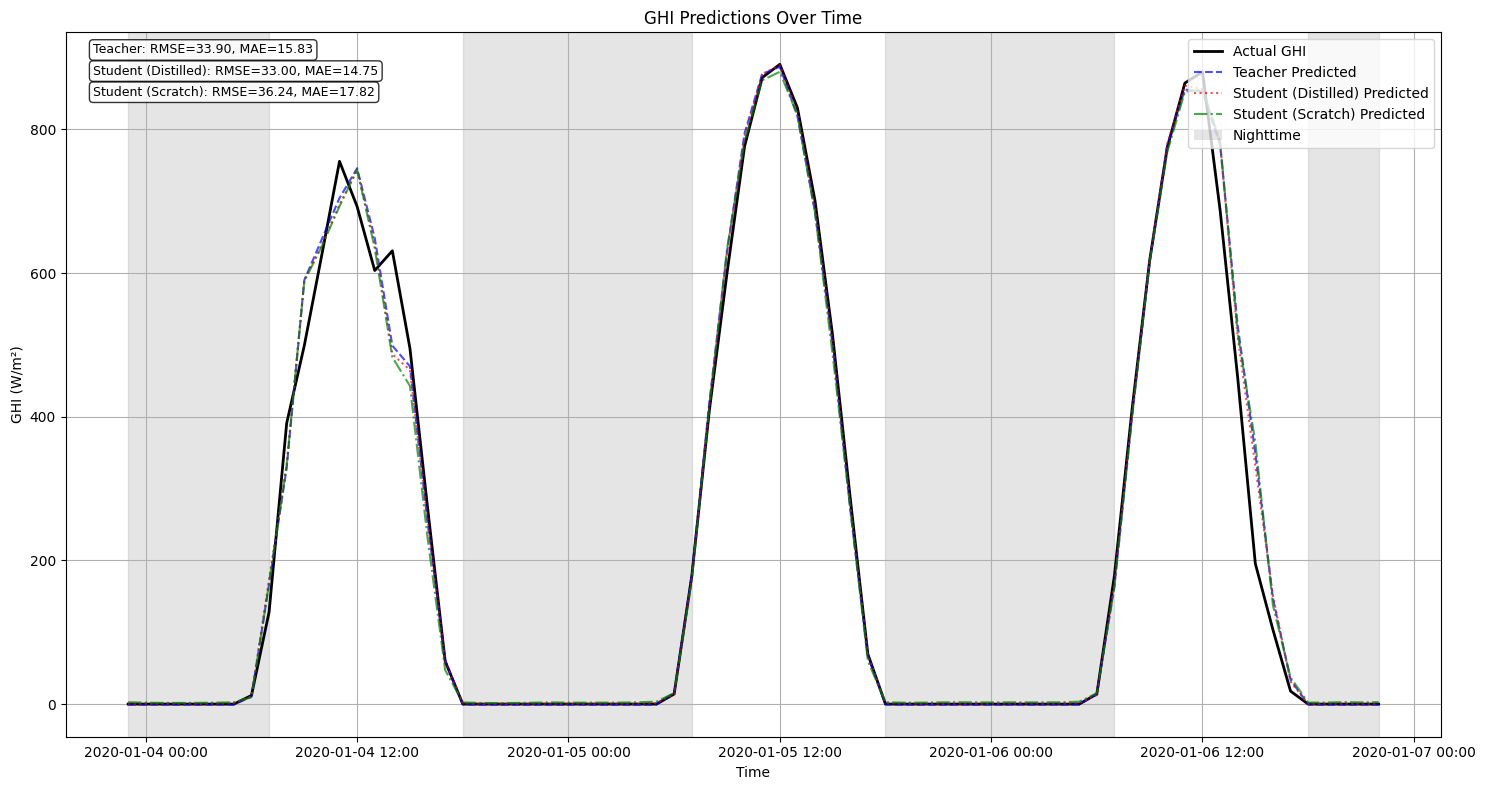

train/distill_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆
train/learning_rate,███████████▄▄▄▄▄▄▄▂▂▂▁▁▁█████████▄▄▄▄▄▂▂
train/loss,▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂
train/task_loss,▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/distill_loss,█▇▃▆▅▂▂▂▁▁▂▂▁▁▂▁▂▁▁▁▂▂▂▁▂
val/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆
val/loss,▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇█▇▇▇▇▇▇▇▇▇▇▇
val/mae,▇▇▄▄▆▄▂▂▂▂▄▇▂▃▃▂▃▂▂▁▂▂▁▁█▅▄▄▆▄▃▅▄▅▂▄▂▄▅▂
val/task_loss,▇▅▅▇▅▃▄▄▃▃▃▂▁▂▁▁▂▂▂▁▁▁▁▁█▆▄▄▆▂▂▃▂▂▂▂▂▃▄▄
train/distill_loss,0.00035


In [13]:
print("\n===== Training Student Model Without Distillation =====")

if is_wandb_enabled():
    wandb.finish()

# Create a new student model with the same architecture
student_scratch_model = create_student_model(original_model)
student_scratch_model = student_scratch_model.to(device)

# Train student model from scratch (without distillation)
print("\nTraining student model from scratch (without distillation)...")

# Train without distillation (from scratch)
student_scratch_model, scratch_val_loss = train_with_distillation(
    teacher_model=original_model,  # Still need teacher model for consistent API
    student_model=student_scratch_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=None,  # Not used when use_distillation=False
    epochs=EPOCHS,
    patience=PATIENCE,
    debug_mode=DEBUG_MODE,
    model_name=f"{model_name}_student_scratch",
    target_scaler=target_scaler,
    config=CONFIG,
    use_distillation=False  # Turn off distillation
)

# Save the trained student model (from scratch)
student_scratch_path = f"checkpoints/{base_checkpoint_name}_student_scratch.pt"
save_model(student_scratch_model, student_scratch_path, temporal_features=SELECTED_FEATURES,
           static_features=STATIC_FEATURES, target_field=TARGET_VARIABLE, config=CONFIG, time_feature_keys=TIME_FEATURES)
print(f"Saved student model trained from scratch to {student_scratch_path}")

# Evaluate student model trained from scratch
student_scratch_metrics = print_model_report(f"{model_name}_student_scratch",
                                          student_scratch_model, test_loader, scalers, device=device)

# Compare all models
print("\n===== Knowledge Distillation Comparison =====")
print(f"{'Model':<36}{'Size (MB)':<12}{'Latency(ms)':<15}{'MAE':<10}")
print('-'*73)
print(f"{'Original Model (Teacher)':<36}{original_metrics['size']:<12.2f}{original_metrics['inference_time']*1000:<15.2f}{original_metrics['metrics']['mae']:<10.4f}")
print(f"{'Student Model with Distillation':<36}{student_metrics['size']:<12.2f}{student_metrics['inference_time']*1000:<15.2f}{student_metrics['metrics']['mae']:<10.4f}")
print(f"{'Student Model from Scratch':<36}{student_scratch_metrics['size']:<12.2f}{student_scratch_metrics['inference_time']*1000:<15.2f}{student_scratch_metrics['metrics']['mae']:<10.4f}")

# Calculate and display improvement percentages
size_reduction = (original_metrics['size'] - student_metrics['size']) / original_metrics['size'] * 100
speed_improvement = (original_metrics['inference_time'] - student_metrics['inference_time']) / original_metrics['inference_time'] * 100
distill_accuracy_change = (original_metrics['metrics']['mae'] - student_metrics['metrics']['mae']) / original_metrics['metrics']['mae'] * 100
scratch_accuracy_change = (original_metrics['metrics']['mae'] - student_scratch_metrics['metrics']['mae']) / original_metrics['metrics']['mae'] * 100
distill_vs_scratch = (student_scratch_metrics['metrics']['mae'] - student_metrics['metrics']['mae']) / student_scratch_metrics['metrics']['mae'] * 100

print(f"\nSize reduction: {size_reduction:.2f}%")
print(f"Inference speed improvement: {speed_improvement:.2f}%")
print(f"Accuracy change (distillation): {distill_accuracy_change:.2f}%")
print(f"Accuracy change (from scratch): {scratch_accuracy_change:.2f}%")
print(f"Distillation vs. From scratch improvement: {distill_vs_scratch:.2f}%")

# Visualize predictions of all models
print("\nGenerating predictions visualization for all models...")
viz_fig = plot_predictions_over_time(
    models=[original_model, student_model, student_scratch_model],
    model_names=["Teacher", "Student (Distilled)", "Student (Scratch)"],
    data_loader=test_loader,
    target_scaler=target_scaler,
    num_samples=72,
    start_idx=40,
    device=device
)

plt.show()
if is_wandb_enabled():
    wandb.finish()

# Add student model from scratch to overall comparison
all_models = [original_metrics, best_pruned_model, student_metrics, student_scratch_metrics]


### Compare Teacher and Student Models Predictions


Model Comparison - Test Set:
                   Teacher Student (Distilled) Student (Scratch)
MSE            2816.766602         2779.568848       2820.168213
RMSE             53.073219           52.721617         53.105256
MAE              24.258215           23.776335         25.345459
MASE              0.482233            0.472653          0.503846
R²                0.969569            0.969971          0.969533
Samples/sec  242555.164202       298495.161942     299679.203002
μs/sample         4.122773            3.350138          3.336902


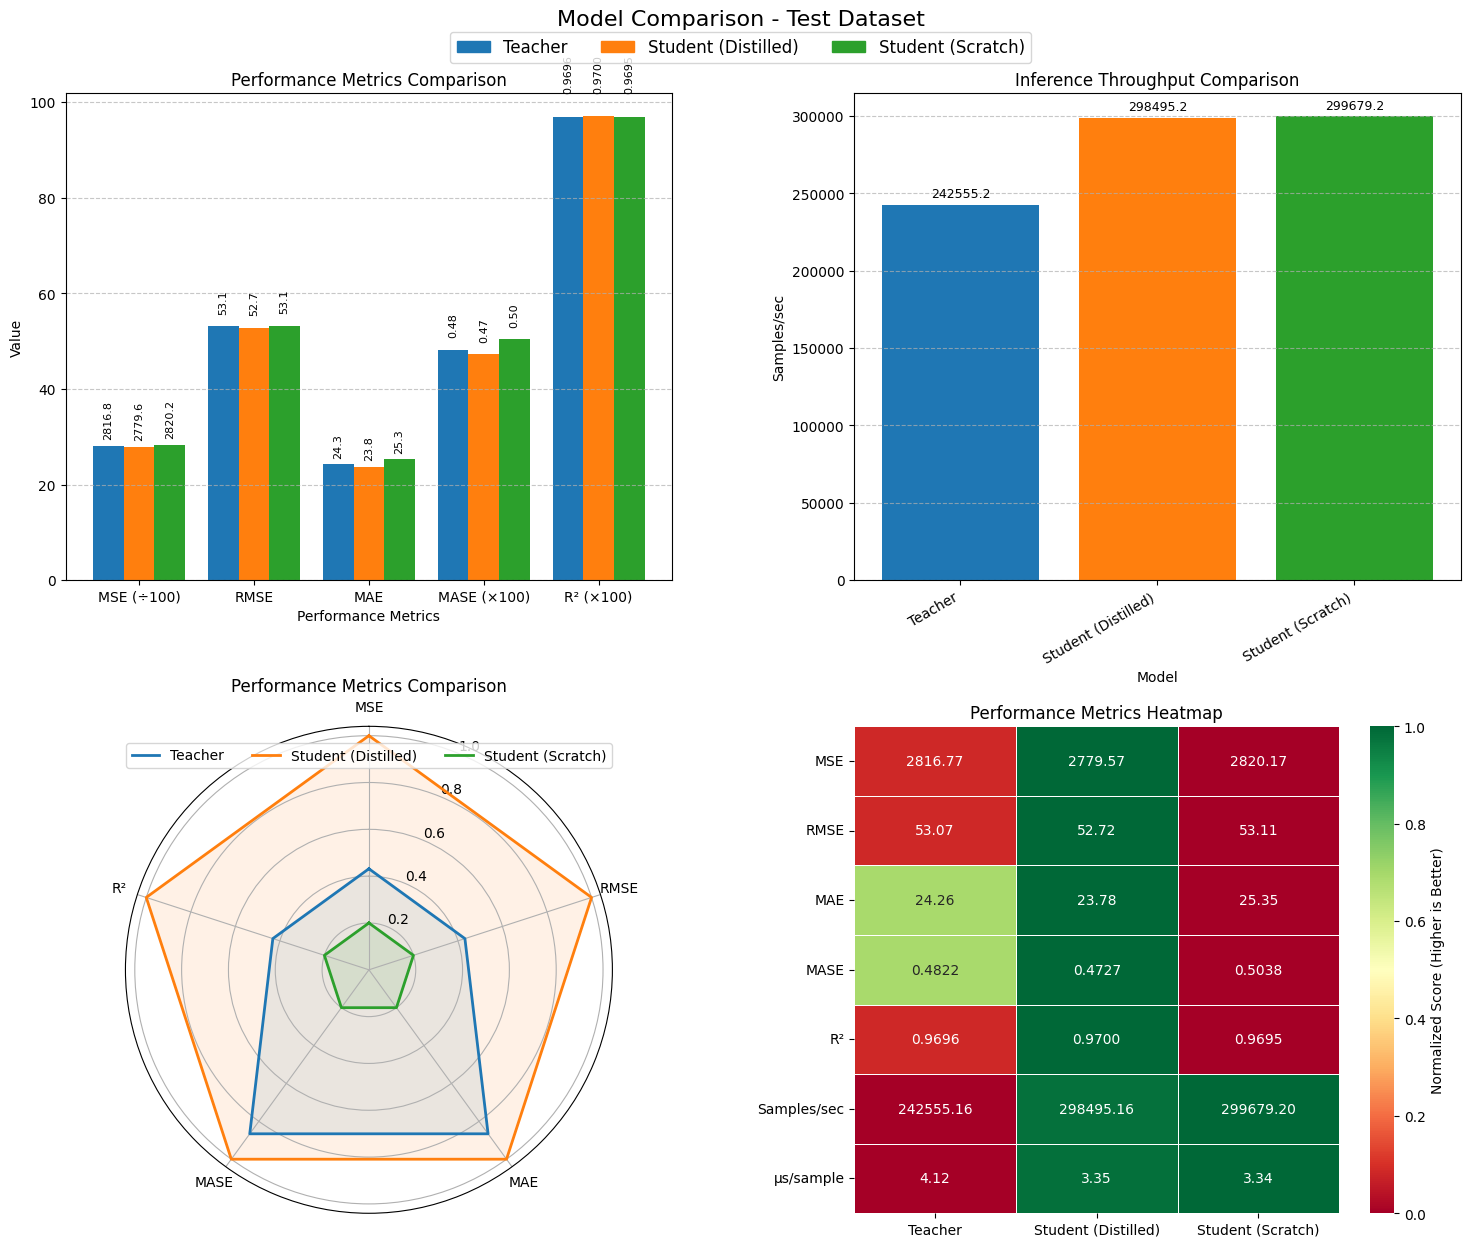

In [14]:
# Compare model performance
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'Teacher': original_metrics['metrics'],
    'Student (Distilled)': student_metrics['metrics'],
    'Student (Scratch)': student_scratch_metrics['metrics']
}
# Drop the 'y_pred' and 'y_true' keys from the model metrics
for model in model_metrics:
    model_metrics[model].pop('y_pred', None)
    model_metrics[model].pop('y_true', None)
    model_metrics[model].pop('nighttime_mask', None)

# Save model metrics to a json file for later use
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_file_path = f'plots/compression_model_metrics_{timestamp}.json'
# Fix TypeError: Object of type float32 is not JSON serializable
for model in model_metrics:
    for key, value in model_metrics[model].items():
        if isinstance(value, np.float32):
            model_metrics[model][key] = float(value)
with open(json_file_path, 'w') as f:
    json.dump(model_metrics, f)

# Compare model performance on test set
fig = compare_models(model_metrics, dataset_name='Test')


### Compare predictions of all models

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


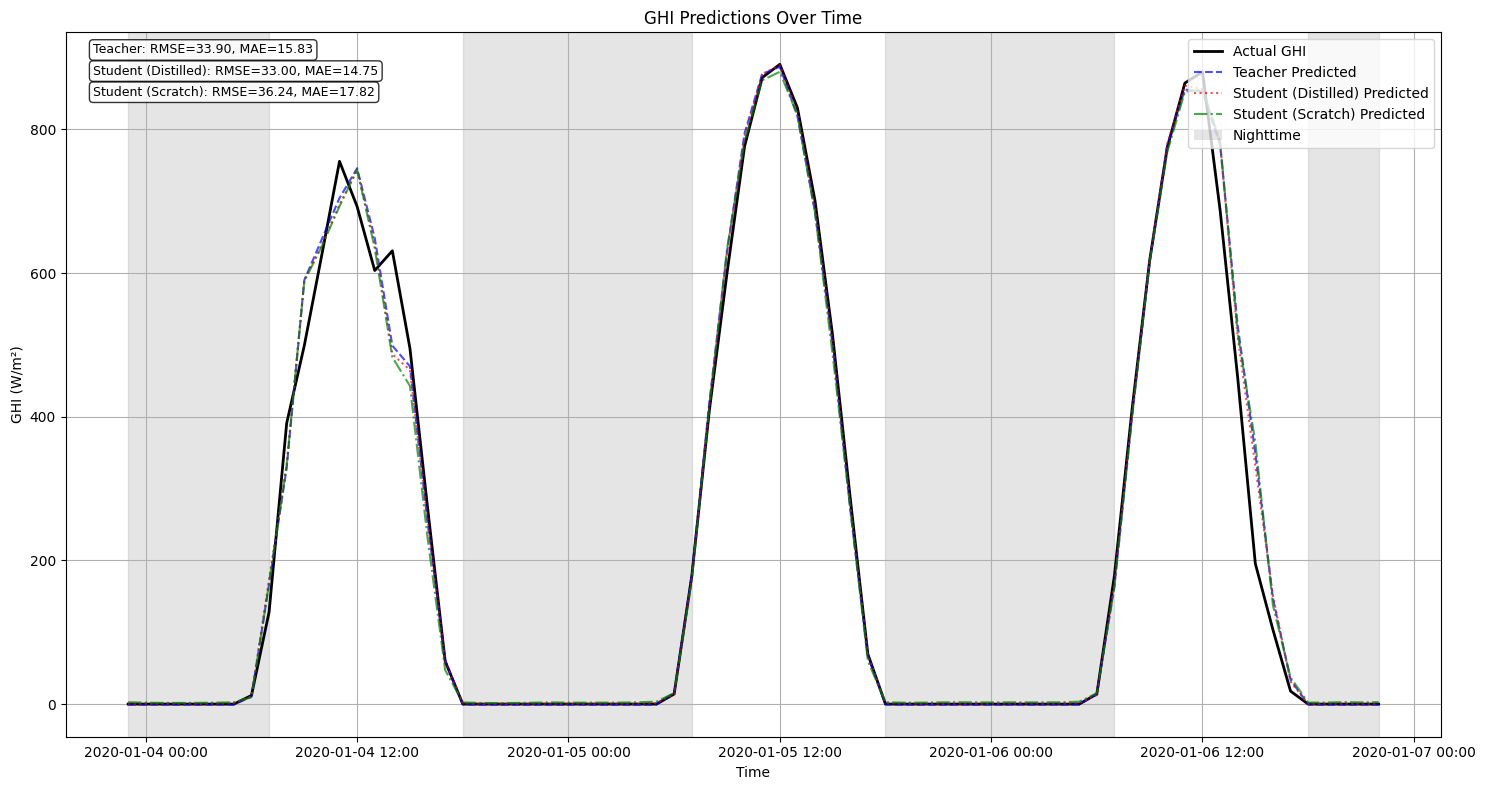

In [15]:

# Plot time series predictions for all models
_ = plot_predictions_over_time(
    models=[original_model, student_model, student_scratch_model],
    model_names=['Teacher', 'Student (Distilled)', 'Student (Scratch)'],
    data_loader=test_loader,
    target_scaler=target_scaler,
    num_samples=72,
    start_idx=40
)
